<a href="https://colab.research.google.com/github/BySanghyeon/AI_Paper_Review/blob/main/GAN/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.datasets as datasets
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import time
from torchvision.transforms.functional import to_pil_image
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Dataset  

In [ ]:
# specify data path
path2data = '/data'
os.makedirs(path2data, exist_ok=True)

In [ ]:
# define transformation
train_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.5],[0.5]),
])

In [ ]:
# Loading MNIST dataset 
train_ds = datasets.MNIST(path2data, 
                          train=True, 
                          transform = train_transform, 
                          download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



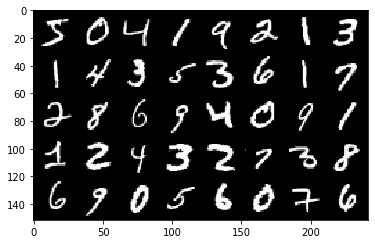

In [ ]:
# check sample image 
img, label = train_ds.data, train_ds.targets

# add dimension
if len(img.shape) == 3:
    img = img.unsqueeze(1) #B*C*H*W

# create grid 
img_grid = utils.make_grid(img[:40], nrow=8, padding=2)

def show(img):
    npimg = img.numpy()
    npimg_tr = npimg.transpose((1,2,0)) # [C,H,H] -> [H,W,C]
    plt.imshow(npimg_tr, interpolation='nearest')

show(img_grid)

In [ ]:
# create DataLoader
train_dl =DataLoader(train_ds, batch_size=64, shuffle=True)

# Modeling

In [ ]:
# setting params
params = {'num_classes':10,
          'nz':100, # 노이즈
          'input_size':(1,28,28)}

In [ ]:
# from torch.nn.modules.activation import LeakyReLU
# Generator
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.num_classes = params['num_classes']
        self.nz = params['nz']
        self.input_size = params['input_size']

        # create a label embedding matrix to join noise and label
        self.label_emb = nn.Embedding(self.num_classes, self. num_classes)


        self.gen = nn.Sequential(
            nn.Linear(self.nz + self.num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), 
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(np.prod(self.input_size))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # join noise and label
        gen_input = torch.cat((self.label_emb(labels), noise),-1)
        x = self.gen(gen_input)
        x = x.view(x.size(0), *self.input_size)
        return x 

x = torch.randn(16, 100, device=device)# noise
label = torch.randint(0,10,(16,), device=device) # label
model_gen= Generator(params).to(device)
out_gen = model_gen(x, label) # Generate fake image
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.input_size = params['input_size']
        self.num_classes = params['num_classes']
        
        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)

        self.dis= nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        dis_input = torch.cat((img.view(img.size(0),-1), self.label_embedding(labels)),-1)

        x = self.dis(dis_input)
        return x 
# check
x = torch.randn(16,1,28,28, device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x, label)
print(out_dis.shape)

torch.Size([16, 1])


In [ ]:
# weight initialization 
def initialize_weights(model):
    classname = model.__class__.__name__
    # fully connected layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# apply weight initialization
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);


# Training 

In [ ]:
# Loss function 
loss_func = nn.BCELoss()
from torch import optim

lr = 2e-4   
beta1 = 0.5
beta2 = 0.999

# optimization
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
nz = params['num_classes']
num_epochs = 50

loss_history={'gen':[],
              'dis':[]}

In [ ]:
# training
batch_count = 0 
start_time = time.time()
model_dis.train() 
model_gen.train() 

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.shape[0]

        xb = xb.to(device)
        yb = yb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device) # fake_label

        # generator 
        model_gen.zero_grad()
        noise = torch.randn(ba_si, 100).to(device) # generate noise
        gen_label = torch.randint(0, 10, (ba_si,)).to(device) # generate label 

        # generate fake image 
        out_gen = model_gen(noise, gen_label)

        # discriminate fake image 
        out_dis = model_dis(out_gen, gen_label)

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()

        # Discriminate real image
        out_dis = model_dis(xb, yb)
        loss_real = loss_func(out_dis, yb_real)

        #Discriminate fake image 
        out_dis = model_dis(out_gen.detach(), gen_label)
        loss_fake = loss_func(out_dis, yb_fake)

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_gen.item())

        batch_count += 1
        if batch_count % 1000 ==0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))




Epoch: 1, G_Loss: 2.040328, D_Loss: 0.335694, time: 0.41 min
Epoch: 2, G_Loss: 1.702610, D_Loss: 0.275458, time: 0.71 min
Epoch: 3, G_Loss: 1.637943, D_Loss: 0.298531, time: 1.03 min
Epoch: 4, G_Loss: 2.421715, D_Loss: 0.211113, time: 1.33 min
Epoch: 5, G_Loss: 1.794709, D_Loss: 0.215029, time: 1.64 min
Epoch: 6, G_Loss: 1.867434, D_Loss: 0.309848, time: 1.95 min
Epoch: 7, G_Loss: 2.506872, D_Loss: 0.409995, time: 2.26 min
Epoch: 8, G_Loss: 2.119184, D_Loss: 0.283949, time: 2.56 min
Epoch: 9, G_Loss: 1.956303, D_Loss: 0.268213, time: 2.87 min
Epoch: 10, G_Loss: 1.797197, D_Loss: 0.289863, time: 3.17 min
Epoch: 11, G_Loss: 2.804176, D_Loss: 0.348986, time: 3.48 min
Epoch: 12, G_Loss: 2.667562, D_Loss: 0.242117, time: 3.78 min
Epoch: 13, G_Loss: 2.153300, D_Loss: 0.306108, time: 4.09 min
Epoch: 14, G_Loss: 2.706040, D_Loss: 0.235749, time: 4.39 min
Epoch: 15, G_Loss: 1.332512, D_Loss: 0.381297, time: 4.70 min
Epoch: 17, G_Loss: 1.970117, D_Loss: 0.329374, time: 5.00 min
Epoch: 18, G_Loss

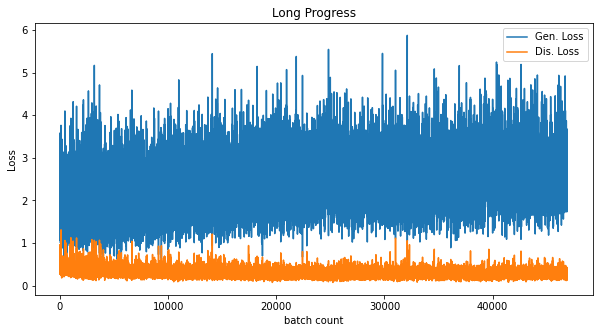

In [ ]:
# plt loss history 
plt.figure(figsize=(10,5))
plt.title('Long Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

# Check images that are generated by G

In [ ]:
# load weights 
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evaluation mode
model_gen.eval()

# generate fake image 
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = model_gen(fixed_noise, label).detach().cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


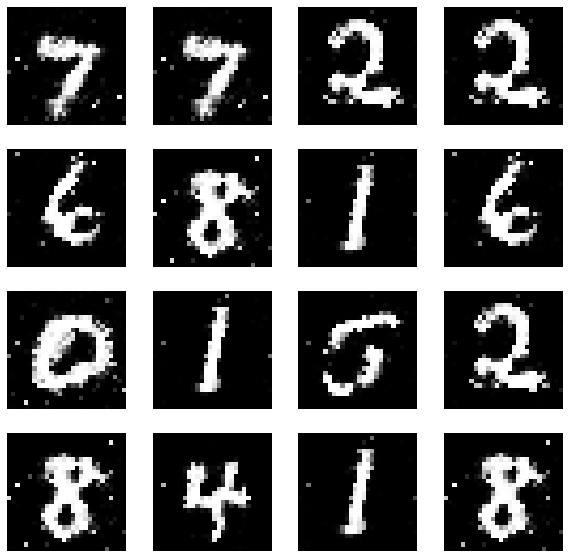

In [ ]:
# visualize fake image 
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4, ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')